In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib2tikz import save as tikz_save
import subprocess
from scipy.optimize import minimize_scalar
from scipy import stats

In [32]:
import json

class myCoder(json.JSONEncoder):
    def encode(self, o):
        if isinstance(o, float):
            o = round(o, 4)
        return super(myCoder, self).encode(o)

json.dumps({'a':1, 'b':1/3}, cls=myCoder)


0.3333

# Price bounds induced by different methods

In [38]:
N = int(1e5)
X = np.arange(0, 1, .01)
Y = np.zeros(shape=(len(X), 2))
W = np.random.normal(size=(2, N))

bar = lambda k,x: np.sqrt(k**2 - x**2)

_p = .9
_r = .5
_qS = -.005
_qV = -.01
_sV = .2
_sS = .15
_Sh= 2*_qS/_sS
_k = 1

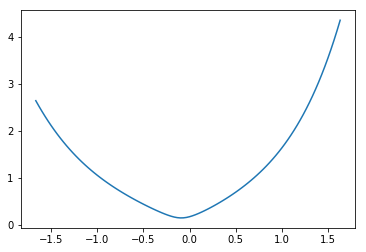

In [41]:

def simy(Sh=_Sh, qS=_qS, qV=_qV, sS=_sS, sV=_sV, r=_r, k=_k):
    gamma_lb = - np.sqrt(Sh**2 - (qS/sS)**2)
    gamma_ub = + np.sqrt(Sh**2 - (qS/sS)**2)
    x = np.arange(gamma_lb, gamma_ub, gamma_ub/50)
    out = []
    for g in x:
        sigmaM = np.array([qS/sS, g])
        muM = -.5 * sigmaM @ sigmaM.T

        sigmaV = np.array([sV*r, sV*bar(1,r)])
        muV = -qV -.5 * sigmaV @ sigmaV.T

        V = np.exp(muV + sigmaV @ W)
        M = np.exp(muM + sigmaM @ W)
        F = np.maximum(0, k-V)
        out.append(np.std(V*M))
    return x, out
        
x, y = simy(Sh=25*_Sh, r=.9)

plt.plot(x,y)

In [563]:
def simulate(Sh=_Sh, qS=_qS, qV=_qV, sS=_sS, sV=_sV, r=_r, k=_k):
    gamma_lb = - np.sqrt(Sh**2 - (qS/sS)**2)
    gamma_ub = + np.sqrt(Sh**2 - (qS/sS)**2)
    
    sigmaM_lb = np.array([qS/sS, gamma_lb])
    muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

    sigmaM_ub = np.array([qS/sS, gamma_ub])
    muM_ub = -.5 * sigmaM_ub @ sigmaM_ub.T

    sigmaM = np.array([qS/sS, 0])
    muM = -.5 * sigmaM @ sigmaM.T

    sigmaV = np.array([sV*r, sV*bar(1,r)])
    muV = -qV -.5 * sigmaV @ sigmaV.T
    
    V = np.exp(muV + sigmaV @ W)
    M_lb = np.exp(muM_lb + sigmaM_lb @ W)
    M = np.exp(muM + sigmaM @ W)
    M_ub = np.exp(muM_ub + sigmaM_ub @ W)
    F = np.maximum(0, V-k)
    return V, M_lb, M, M_ub, F

### varying the correlation

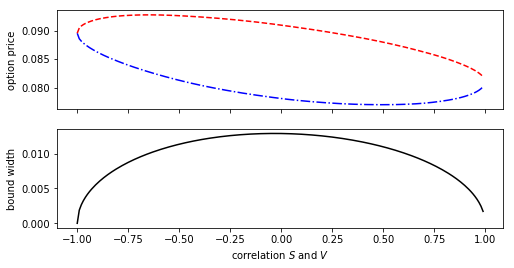

In [116]:
X = np.arange(-1, 1.0, .01)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for r, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(r=r, Sh=_Sh, k=1)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, (ax1, ax3) = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
ax1.plot(X, YF.T[0], 'b-.', X, YF.T[1], 'r--')
ax3.plot(X, YF[:,1] - YF[:,0], 'k');
ax1.set_ylabel('option price')
ax3.set_ylabel('bound width')
ax3.set_xlabel('correlation $S$ and $V$')

# tikz_save('../scriptie/img/varycorrelation.tex', figureheight='1.5in', figurewidth='4in')
# print(subprocess.check_output(r'cd ..\scriptie\ && git commit -a -m "img" && git pull && git push', shell=True).decode('utf-8'))

In [124]:
1/77, _Sh/5, np.sqrt(_Sh**2 - (_qS/_sS)**2)*_sV

(0.012987012987012988, -0.013333333333333332, 0.011547005383792516)

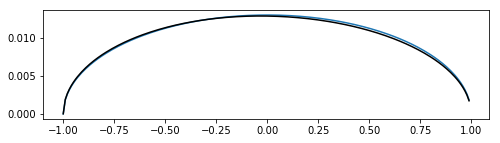

In [129]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(X, np.sqrt(1-np.power(X,2))*.013)
ax.plot(X, YF[:,1] - YF[:,0], 'k');

### Varying the unobserved return process

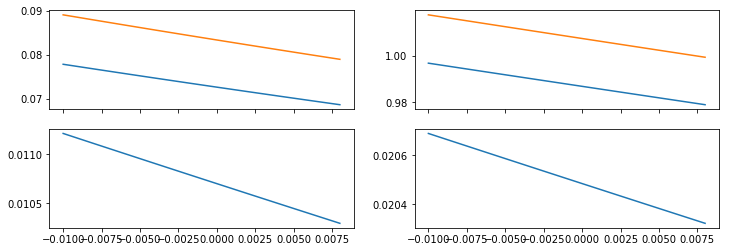

In [232]:
X = np.arange(_qS, -_qS, .001)*2
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for qV, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(qV=qV)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

### Varying the strike

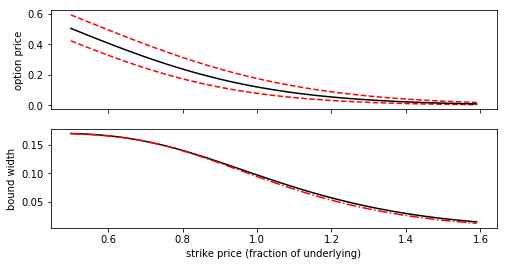

In [383]:
X = np.arange(.5,1.6,.01)
YF = np.zeros((len(X), 3))

for k, YFi in zip(X, YF):
    V, M_lb, M, M_ub, F = simulate(k=k, Sh=5*_Sh, sV=.3)
    YFi += np.array([np.mean(M_lb*F), np.mean(M*F), np.mean(M_ub*F)])

fix, (ax1, ax3) = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
ax1.plot(X, YF.T[0], 'r--', X, YF.T[1], 'k-', X, YF.T[2], 'r--', )
ax3.plot(X, (YF[:,2] - YF[:,0]), 'k');
ax3.set_xlabel('strike price (fraction of underlying)')
ax1.set_ylabel('option price')
ax3.set_ylabel('bound width')

# ax3.plot(X, stats.norm.cdf(5*(1-X))*.081)
ax3.plot(X, stats.lognorm.sf(X-.04, s=.3)*.17, 'r-.')

# tikz_save('../scriptie/img/varystrike.tex', figureheight='1.5in', figurewidth='4in')
# print(subprocess.check_output(r'cd ..\scriptie\ && git commit -a -m "img" && git pull && git push', shell=True).decode('utf-8'))

### Varying the unobserved volatility process

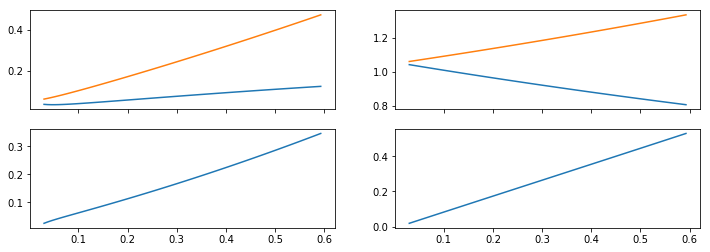

In [57]:
X = np.arange(.2*_sS, 4*_sS, _sS/20)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for sV, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(sV=sV)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);


### Varying the sharpe ratio limit

In [566]:
np.array([qS/sS, Sh]), qS, sS

(array([array([ 0.00507621,  0.01068959,  0.00563154]), 0.033333333333333333], dtype=object),
 0.005,
 array([ 0.98498753,  0.46774461,  0.88785608]))

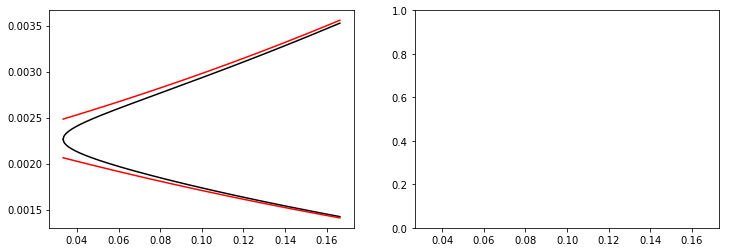

In [600]:
X = -_qS/_sS*np.arange(1, 5, .01)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for Sh, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(Sh=Sh, k=1.5, r=0)
    
    
    sigmaM = np.array([_qS/_sS, Sh])
    muM = -.5 * sigmaM @ sigmaM.T
    M_ = np.exp(muM + sigmaM @ W)
    sigmaM = np.array([_qS/_sS, -Sh])
    _M = np.exp(muM + sigmaM @ W)
    
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_*F), np.mean(_M*F)])

fix, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF, 'k')
ax1.plot(X, YV, 'r')

a,b,c,d = -_qS/_sS,.006,np.exp(-_qV),1.0
# X = np.arange(0,2,.01)
# ax1.plot(X, c+b/a*np.sqrt(np.power(X,2)-np.power(a,2)), 'r-.', X, c-b/a*np.sqrt(np.power(X,2)-np.power(a,2)), 'r-.')
# ax2.plot(X, c+b/a*X*d, 'r-.', X, c-b/a*X/d, 'r-.')


Updating ca1ecfd..9e57774
Fast-forward
 img/varybound.tex     | 3300 ++++++++++++++++++++++++-------------------------
 sections/empirics.tex |    4 +-
 2 files changed, 1653 insertions(+), 1651 deletions(-)

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
[master 731117e] img
 1 file changed, 1650 insertions(+), 1650 deletions(-)



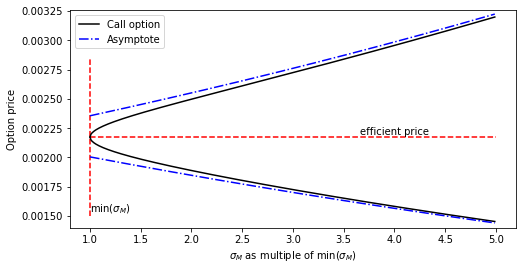

In [598]:
a,b,c = -_qS/_sS,.0002, .00222#.0033,.08355
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(X/a, YF.T[0], 'k')
ax.plot(X/a, YF.T[1], 'k', label='Call option')
ax.plot(X/a, YV.T[0], 'b-.')
ax.plot(X/a, YV.T[1], 'b-.', label='Asymptote')


ax.vlines(1, .0015, .00285, 'r', 'dashed')
ax.text(1, .0015, '$\min(\sigma_M)$', horizontalalignment='left', verticalalignment='bottom', withdash=True)

ax.hlines(.002175, 1, 5, 'r', 'dashed')
ax.text(4, .002175, 'efficient price', horizontalalignment='center', verticalalignment='bottom')

# d = 1.0
# ax.plot(X/a, c+b/a*X*d, 'b-.')
# ax.plot(X/a, c-b/a*X/d, 'b-.', label='asymptote $\gamma_t$')
# _sV,_r,_qS,_qV,_sV,_sS,_Sh, _sS*_sV**2
ax.set_xlabel('$\sigma_M$ as multiple of $\min(\sigma_M)$')
ax.set_ylabel('Option price')
ax.set_ylim(.0014,0.003255)

plt.legend()

print(subprocess.check_output(r'cd ..\scriptie\ && git pull', shell=True).decode('utf-8'))
tikz_save('../scriptie/img/varybound.tex', figureheight='2.5in', figurewidth='4in')
print(subprocess.check_output(r'cd ..\scriptie\ && git commit -a -m "img" && git push', shell=True).decode('utf-8'))

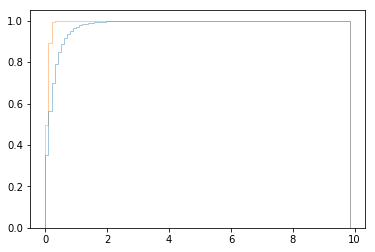

In [467]:
plt.hist([(M_ub*F)[F>0], (M_lb*F)[F>0]], bins=100, alpha=.4, normed=True, cumulative=True,rwidth=1, histtype='step');

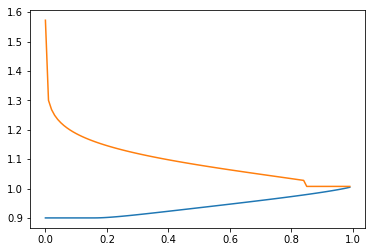

In [223]:
for p, yi in zip(X, Y):
    x = np.maximum(k, np.exp(mux + sigmax @ W))
    #percentile bounds
    yi += np.mean(x[x <= np.percentile(x, 100*p)]), np.mean(x[-x <= np.percentile(-x, 100*p)])

plt.plot(X,Y)